In [3]:
import pandas as pd
import numpy as np
import os
import sys
import boto3
import awswrangler as wr

from sklearn.model_selection import train_test_split


# Cargar bases a S3

In [4]:
# Abrir un cliente de S3
session = boto3.Session(profile_name='arquitectura',region_name="us-east-1")
s3 = session.client('s3')

In [5]:
# Crear un nuevo Bucket
# OJO: Aqui cambia el nombre del bucket, utiliza tu nombre como sufijo, para
# que sea único en el mundo, si no te va a salir error. Si tuviste éxito, el
# API de boto3 te va a regresar un HTTPStatusCode de 200. Eso es éxito.
BUCKET_NAME = "itam-analytics-ogf"
#s3.create_bucket(Bucket=BUCKET_NAME)

In [4]:
# Cargo las bases para poder juntarlas
df_buro_2022 = pd.read_csv("../data/BURO_2022.csv")
df_buro_2023 = pd.read_csv("../data/BURO_2023.csv")
df_buro_2024 = pd.read_csv("../data/BURO_2024.csv")
df_buro_2025 = pd.read_csv("../data/BURO_2025.csv")

# Juntar las bases
df_buro = pd.concat([df_buro_2022, df_buro_2023, df_buro_2024, df_buro_2025])

# Guardar la base localmente
df_buro.to_csv("../data/BURO_COMPLETA.csv", index=False)


In [5]:
# Cargo los archivos a S3
s3.upload_file(Filename="../data/BURO_COMPLETA.csv", 
               Bucket=BUCKET_NAME, 
               Key="analisis_variables_buro/db_buro/BURO_COMPLETA.csv")

s3.upload_file(Filename="../data/PERFORMANCE.csv", 
               Bucket=BUCKET_NAME, 
               Key="analisis_variables_buro/db_performance/PERFORMANCE.csv")

# Creación base de datos en Glue

In [6]:
from botocore.config import Config
my_config = Config(
    region_name = 'us-east-1'
)

glue = boto3.client('glue', config=my_config)

In [7]:
response = glue.create_database(
    DatabaseInput={
        'Name': 'analisis_buro',
        'Description': 'Variables de buro de credito e indicadores de performance',
    },
)
response

{'ResponseMetadata': {'RequestId': '69615d58-6f37-4cf0-a6a5-647dbad74ffb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 May 2025 17:00:52 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '69615d58-6f37-4cf0-a6a5-647dbad74ffb',
   'cache-control': 'no-cache'},
  'RetryAttempts': 0}}

# Creación de tablas en Athena

In [11]:
# Obtener nombre de columnas y tipo de dato, y guardarlos en un CSV
df_buro.dtypes.reset_index().rename(columns={"index": "columna", 0: "tipo_dato"}).to_csv("../data/columnas_buro.csv", index=False)



In [13]:
df_buro.tail()

,MES,CLIENTEID,SH01_Hit_Indicator,Score_1,Score_1_Derogatory_Alert,Number_of_trades,Number_of_trades_opened_in_past_12_months,Number_of_trades_opened_in_past_24_months,Months_since_oldest_account_opened,Months_since_most_recent_account_opened,...,Number_of_inquiries,Number_or_inquiries_in_last_6_months,Months_since_most_recent_inquiry,Score_1_Indicator_Flag,Deceased_Flag,Frozen_Flag_Indicator,Fact_Act_Address_Type,FECHA_CONSULTA,FECHA_INFORMACION,MES_INFORMACION
124138,202502,4894761,True,559.0,I,3.0,1.0,3.0,14.0,6.0,...,3.0,1.0,6.0,NaN,NaN,NaN,NaN,2025-02-01,2025-01-01,202501
124139,202502,4615521,True,642.0,I,6.0,1.0,1.0,129.0,7.0,...,1.0,0.0,7.0,NaN,NaN,NaN,NaN,2025-02-01,2025-01-01,202501
124140,202502,4711834,True,684.0,I,13.0,1.0,3.0,214.0,3.0,...,6.0,2.0,3.0,NaN,NaN,NaN,NaN,2025-02-01,2025-01-01,202501
124141,202503,4685193,True,624.0,I,9.0,2.0,3.0,53.0,3.0,...,15.0,0.0,8.0,NaN,NaN,NaN,NaN,2025-03-01,2025-02-01,202502
124142,202504,4673241,True,675.0,I,26.0,3.0,7.0,104.0,2.0,...,7.0,4.0,2.0,NaN,NaN,NaN,NaN,2025-04-01,2025-03-01,202503


In [16]:

texto = '''
`MES` INT
`CLIENTEID` INT
`SH01_Hit_Indicator` INT
`Score_1`,float64
`Score_1_Derogatory_Alert` STRING
`Number_of_trades`,float64
`Number_of_trades_opened_in_past_12_months`,float64
`Number_of_trades_opened_in_past_24_months`,float64
`Months_since_oldest_account_opened`,float64
`Months_since_most_recent_account_opened`,float64
`Number_of_trades_with_current_balance_balance_greater_than_0`,float64
`Number_of_bankcard_accounts`,float64
`Number_of_currently_active_bankcard_accounts`,float64
`Number_of_bankcard_accounts_opened_in_past_12_months`,float64
`Number_of_bankcard_accounts_opened_in_past_24_months`,float64
`Months_since_oldest_bankcard_account_opened`,float64
`Months_since_most_recent_bankcard_account_opened`,float64
`Number_of_bankcard_accounts_with_current_balance_balance_greater_than_0`,float64
`Number_of_bank_installment_accounts`,float64
`Number_of_bank_installment_accounts_opened_in_past_12_months`,float64
`Number_of_bank_installment_accounts_opened_in_past_24_months`,float64
`Months_since_oldest_bank_installment_account_opened`,float64
`Number_of_finance_installment_trades`,float64
`Number_of_finance_installment_trades_opened_in_past_12_months`,float64
`Number_of_finance_installment_trades_opened_in_past_24_months`,float64
`Months_since_most_recent_activity`,float64
`Months_on_file`,float64
`Number_of_installment_accounts`,float64
`Number_of_currently_active_installment_trades`,float64
`Number_of_installment_accounts_opened_in_past_12_months`,float64
`Number_of_installment_accounts_opened_in_past_24_months`,float64
`Months_since_oldest_installment_account_opened`,float64
`Months_since_most_recent_installment_accounts_opened`,float64
`Number_of_installment_trades_with_balance_balance_greater_than_0`,float64
`Number_of_mortgage_accounts`,float64
`Number_of_currently_active_mortgage_accounts`,float64
`Number_of_mortgage_accounts_opened_in_past_12_months`,float64
`Number_of_mortgage_accounts_opened_in_past_24_months`,float64
`Months_since_oldest_mortgage_account_opened`,float64
`Months_since_most_recent_mortgage_account_opened`,float64
`Number_of_mortgage_accounts_with_current_balance_greater_than_0`,float64
`Number_of_personal_finance_accounts`,float64
`Number_of_currently_active_personal_finance_accounts`,float64
`Number_of_personal_finance_accounts_opened_in_past_12_months`,float64
`Number_of_personal_finance_accounts_opened_in_past_24_months`,float64
`Months_since_oldest_personal_finance_account_opened`,float64
`Months_since_most_recent_personal_finance_account_opened`,float64
`Number_of_personal_finance_trades_with_balance_balance_greater_than_0`,float64
`Number_of_revolving_accounts`,float64
`Number_of_currently_active_revolving_trades`,float64
`Number_of_revolving_trades_opened_in_past_12_months`,float64
`Number_of_revolving_trades_opened_in_past_24_months`,float64
`Months_since_oldest_revolving_account_opened`,float64
`Months_since_most_recent_revolving_account_opened`,float64
`Number_of_revolving_trades_with_balance_balance_greater_than_0`,float64
`Number_of_retail_trades`,float64
`Number_of_currently_active_retail_trades`,float64
`Number_of_retail_trades_opened_in_past_12_months`,float64
`Number_of_retail_trades_opened_in_past_24_months`,float64
`Months_since_oldest_retail_account_opened`,float64
`Months_since_most_recent_retail_account_opened`,float64
`Number_of_retail_trades_with_current_balance_balance_greater_than_0`,float64
`Number_of_open_trades`,float64
`Number_of_open_revolving_trades`,float64
`Number_of_accounts_opened_since_the_last_maximum_delinquency_of_60_day_past_due`,float64
`Number_of_accounts_opened_since_the_last_charge_off`,float64
`Number_of_accounts_with_a_maximum_delinquency_of_60_days_past_due_since_opening_a_new_account_within_the_last_12_months`,float64
`Number_of_accounts_with_a_maximum_delinquency_of_90_days_plus_past_due_since_opening_a_new_account_within_the_last_12_months`,float64
`Number_of_accounts_Charged_Off_since_opening_a_new_account_within_the_last_12_months`,float64
`Number_of_satisfactory_trades`,float64
`Months_since_most_recent_delinquency`,float64
`Number_of_satisfactory_bankcard_accounts`,float64
`Months_since_most_recent_bankcard_delinquency`,float64
`Number_of_satisfactory_bank_installment_accounts`,float64
`Number_of_charge_offs_within_12_months_CHGOFF12`,float64
`Highest_collection_amount_owed_in_12_months_COLAMT12`,float64
`Number_of_collection_inquiries_COLINQ`,float64
`Number_of_collections_in_12_months_COLLEC12`,float64
`Number_of_collections_in_12_months_excluding_medical_collections_COLXMD12`,float64
`Number_of_satisfactory_finance_installment_trades`,float64
`Number_of_30_day_ratings`,float64
`Number_of_60_day_ratings`,float64
`Number_of_90_day_ratings`,float64
`Number_of_120_day_ratings`,float64
`Number_of_30_and_60_day_ratings`,float64
`Number_of_30_day_or_worse_ratings`,float64
`Number_of_60_day_or_worse_ratings`,float64
`Number_of_90_day_or_worse_ratings`,float64
`Number_of_trades_with_maximum_delinquency_02_in_last_3_months`,float64
`Number_of_trades_with_maximum_delinquency_02_in_last_6_months`,float64
`Number_of_trades_with_maximum_delinquency_02_in_last_12_months`,float64
`Number_of_trades_with_maximum_delinquency_02_in_last_24_months`,float64
`Number_of_trades_with_maximum_delinquency_03_in_last_3_months`,float64
`Number_of_trades_with_maximum_delinquency_03_in_last_6_months`,float64
`Number_of_trades_with_maximum_delinquency_03_in_last_12_months`,float64
`Number_of_trades_with_maximum_delinquency_03_in_last_24_months`,float64
`Number_of_trades_with_maximum_delinquency_04_in_last_3_months`,float64
`Number_of_trades_with_maximum_delinquency_04_in_last_6_months`,float64
`Number_of_trades_with_maximum_delinquency_04_in_last_12_months`,float64
`Number_of_trades_with_maximum_delinquency_04_in_last_24_months`,float64
`Number_of_trades_ever_30_or_more_days_past_due`,float64
`Number_of_trades_ever_60_or_more_days_past_due`,float64
`Number_of_trades_ever_90_or_more_days_past_due`,float64
`Number_of_trades_ever_120_or_more_days_past_due`,float64
`Percent_of_trades_delinquent`,float64
`Number_of_trades_30_or_more_days_past_due_in_last_3_months`,float64
`Number_of_trades_30_or_more_days_past_due_in_last_6_months`,float64
`Number_of_trades_30_or_more_days_past_due_in_last_12_months`,float64
`Number_of_trades_30_or_more_days_past_due_in_last_24_months`,float64
`Number_of_trades_60_or_more_days_past_due_in_last_3_months`,float64
`Number_of_trades_60_or_more_days_past_due_in_last_6_months`,float64
`Number_of_trades_60_or_more_days_past_due_in_last_12_months`,float64
`Number_of_trades_60_or_more_days_past_due_in_last_24_months`,float64
`Number_of_trades_90_or_more_days_past_due_in_last_3_months`,float64
`Number_of_trades_90_or_more_days_past_due_in_last_6_months`,float64
`Number_of_trades_90_or_more_days_past_due_in_last_12_months`,float64
`Number_of_trades_90_or_more_days_past_due_in_last_24_months`,float64
`Number_of_trades_currently_past_due_updated_in_past_2_months`,float64
`Number_of_trades_currently_30_days_past_due_updated_in_past_2_months`,float64
`Number_of_trades_currently_60_days_past_due_updated_in_past_2_months`,float64
`Number_of_trades_currently_90_days_past_due_updated_in_past_2_months`,float64
`Number_of_trades_currently_120_days_past_due_updated_in_past_2_months`,float64
`Total_amount_now_past_due`,float64
`Number_of_derogatory_public_records`,float64
`Number_of_public_record_bankruptcies`,float64
`Months_since_most_recent_derogatory_public_record`,float64
`Number_of_satisfactory_mortgage_accounts`,float64
`Months_since_most_recent_mortgage_account_delinquency`,float64
`Number_of_satisfactory_personal_finance_accounts`,float64
`Months_since_most_recent_personal_finance_delinquency`,float64
`Number_of_satisfactory_revolving_accounts`,float64
`Months_since_most_recent_revolving_delinquency`,float64
`Number_of_satisfactory_retail_trades`,float64
`Months_since_most_recent_retail_delinquency`,float64
`Number_of_public_record_and_account_line_derogatory_items_greater_than_100`,float64
`Months_since_most_recent_60_day_or_worse_rating`,float64
`Months_since_most_recent_90_day_or_worse_rating`,float64
`Total_public_record_amounts`,float64
`Total_collection_amounts_ever_owed`,float64
`Number_of_tax_liens`,float64
`Total_high_credit_credit_limit`,float64
`Total_bankcard_high_credit_credit_limit`,float64
`Total_installment_high_credit_credit_limit`,float64
`Total_mortgage_high_credit_credit_limit`,float64
`Total_personal_finance_high_credit_credit_limit`,float64
`Total_revolving_high_credit_credit_limit`,float64
`Total_retail_high_credit_credit_limit`,float64
`Highest_retail_high_credit_credit_limit`,float64
`Total_current_balance_of_all_trades`,float64
`Average_current_balance_of_all_trades`,float64
`Total_current_balance_of_all_trades_excluding_mortgage`,float64
`Maximum_balance_owed_on_all_bankcard_accounts`,float64
`Total_balance_of_all_bankcard_accounts`,float64
`Average_current_balance_of_all_bankcard_accounts`,float64
`Maximum_balance_owed_on_all_finance_installment_trades`,float64
`Total_current_balance_of_all_installment_accounts`,float64
`Average_balance_of_all_installment_trades`,float64
`Maximum_current_balance_owed_on_all_mortgage_accounts`,float64
`Total_current_balance_of_all_mortgage_accounts`,float64
`Average_current_balance_of_mortgage_accounts`,float64
`Maximum_balance_owed_on_all_personal_finance_trades`,float64
`Total_current_balance_of_all_personal_finance_accounts`,float64
`Average_balance_of_all_personal_finance_trades`,float64
`Maximum_current_balance_owed_on_all_revolving_accounts`,float64
`Total_current_balance_of_all_revolving_accounts`,float64
`Average_current_balance_of_all_revolving_accounts`,float64
`Maximum_balance_owed_on_all_retail_trades`,float64
`Total_current_balance_of_all_retail_trades`,float64
`Average_current_balance_of_all_retail_trades`,float64
`Number_of_non_installment_trades_50_of_limit`,float64
`Percent_of_active_trades_with_current_balance_balance_greater_than_0`,float64
`Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_trades`,float64
`Percentage_of_all_bankcard_accounts_50_of_limit`,float64
`Percentage_of_all_bankcard_accounts_75_of_limit`,float64
`Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_bankcard_accounts`,float64
`Total_open_to_buy_on_revolving_bankcards_includes_retail_and_gascards`,float64
`Ratio_of_total_balance_to_high_credit_credit_limit_for_all_bank_revolving_accounts`,float64
`Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_installment_accounts`,float64
`Ratio_of_current_balance_to_high_credit_credit_limit_on_mortgage_accounts`,float64
`Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_personal_finance_accounts`,float64
`Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_revolving_accounts`,float64
`Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_retail_trades`,float64
`Number_of_inquiries`,float64
`Number_or_inquiries_in_last_6_months`,float64
`Months_since_most_recent_inquiry`,float64
`Score_1_Indicator_Flag`,float64
`Deceased_Flag`,float64
`Frozen_Flag_Indicator`,float64
`Fact_Act_Address_Type`,float64
`FECHA_CONSULTA`,float64
`FECHA_INFORMACION`,float64
`MES_INFORMACION`,float64
'''

In [ ]:
# Reemplazar ,float64 por DOUBLE
texto = texto.replace(",float64", " DOUBLE")
print(texto)

In [34]:
query = '''
     CREATE EXTERNAL TABLE IF NOT EXISTS `analisis_buro`.`variables_buro` (
     `MES` INT,
     `CLIENTEID` INT,
     `SH01_Hit_Indicator` INT,
     `Score_1` DOUBLE,
     `Score_1_Derogatory_Alert` STRING,
     `Number_of_trades` DOUBLE,
     `Number_of_trades_opened_in_past_12_months` DOUBLE,
     `Number_of_trades_opened_in_past_24_months` DOUBLE,
     `Months_since_oldest_account_opened` DOUBLE,
     `Months_since_most_recent_account_opened` DOUBLE,
     `Number_of_trades_with_current_balance_balance_greater_than_0` DOUBLE,
     `Number_of_bankcard_accounts` DOUBLE,
     `Number_of_currently_active_bankcard_accounts` DOUBLE,
     `Number_of_bankcard_accounts_opened_in_past_12_months` DOUBLE,
     `Number_of_bankcard_accounts_opened_in_past_24_months` DOUBLE,
     `Months_since_oldest_bankcard_account_opened` DOUBLE,
     `Months_since_most_recent_bankcard_account_opened` DOUBLE,
     `Number_of_bankcard_accounts_with_current_balance_balance_greater_than_0` DOUBLE,
     `Number_of_bank_installment_accounts` DOUBLE,
     `Number_of_bank_installment_accounts_opened_in_past_12_months` DOUBLE,
     `Number_of_bank_installment_accounts_opened_in_past_24_months` DOUBLE,
     `Months_since_oldest_bank_installment_account_opened` DOUBLE,
     `Number_of_finance_installment_trades` DOUBLE,
     `Number_of_finance_installment_trades_opened_in_past_12_months` DOUBLE,
     `Number_of_finance_installment_trades_opened_in_past_24_months` DOUBLE,
     `Months_since_most_recent_activity` DOUBLE,
     `Months_on_file` DOUBLE,
     `Number_of_installment_accounts` DOUBLE,
     `Number_of_currently_active_installment_trades` DOUBLE,
     `Number_of_installment_accounts_opened_in_past_12_months` DOUBLE,
     `Number_of_installment_accounts_opened_in_past_24_months` DOUBLE,
     `Months_since_oldest_installment_account_opened` DOUBLE,
     `Months_since_most_recent_installment_accounts_opened` DOUBLE,
     `Number_of_installment_trades_with_balance_balance_greater_than_0` DOUBLE,
     `Number_of_mortgage_accounts` DOUBLE,
     `Number_of_currently_active_mortgage_accounts` DOUBLE,
     `Number_of_mortgage_accounts_opened_in_past_12_months` DOUBLE,
     `Number_of_mortgage_accounts_opened_in_past_24_months` DOUBLE,
     `Months_since_oldest_mortgage_account_opened` DOUBLE,
     `Months_since_most_recent_mortgage_account_opened` DOUBLE,
     `Number_of_mortgage_accounts_with_current_balance_greater_than_0` DOUBLE,
     `Number_of_personal_finance_accounts` DOUBLE,
     `Number_of_currently_active_personal_finance_accounts` DOUBLE,
     `Number_of_personal_finance_accounts_opened_in_past_12_months` DOUBLE,
     `Number_of_personal_finance_accounts_opened_in_past_24_months` DOUBLE,
     `Months_since_oldest_personal_finance_account_opened` DOUBLE,
     `Months_since_most_recent_personal_finance_account_opened` DOUBLE,
     `Number_of_personal_finance_trades_with_balance_balance_greater_than_0` DOUBLE,
     `Number_of_revolving_accounts` DOUBLE,
     `Number_of_currently_active_revolving_trades` DOUBLE,
     `Number_of_revolving_trades_opened_in_past_12_months` DOUBLE,
     `Number_of_revolving_trades_opened_in_past_24_months` DOUBLE,
     `Months_since_oldest_revolving_account_opened` DOUBLE,
     `Months_since_most_recent_revolving_account_opened` DOUBLE,
     `Number_of_revolving_trades_with_balance_balance_greater_than_0` DOUBLE,
     `Number_of_retail_trades` DOUBLE,
     `Number_of_currently_active_retail_trades` DOUBLE,
     `Number_of_retail_trades_opened_in_past_12_months` DOUBLE,
     `Number_of_retail_trades_opened_in_past_24_months` DOUBLE,
     `Months_since_oldest_retail_account_opened` DOUBLE,
     `Months_since_most_recent_retail_account_opened` DOUBLE,
     `Number_of_retail_trades_with_current_balance_balance_greater_than_0` DOUBLE,
     `Number_of_open_trades` DOUBLE,
     `Number_of_open_revolving_trades` DOUBLE,
     `Number_of_accounts_opened_since_the_last_maximum_delinquency_of_60_day_past_due` DOUBLE,
     `Number_of_accounts_opened_since_the_last_charge_off` DOUBLE,
     `Number_of_accounts_with_a_maximum_delinquency_of_60_days_past_due_since_opening_a_new_account_within_the_last_12_months` DOUBLE,
     `Number_of_accounts_with_a_maximum_delinquency_of_90_days_plus_past_due_since_opening_a_new_account_within_the_last_12_months` DOUBLE,
     `Number_of_accounts_Charged_Off_since_opening_a_new_account_within_the_last_12_months` DOUBLE,
     `Number_of_satisfactory_trades` DOUBLE,
     `Months_since_most_recent_delinquency` DOUBLE,
     `Number_of_satisfactory_bankcard_accounts` DOUBLE,
     `Months_since_most_recent_bankcard_delinquency` DOUBLE,
     `Number_of_satisfactory_bank_installment_accounts` DOUBLE,
     `Number_of_charge_offs_within_12_months_CHGOFF12` DOUBLE,
     `Highest_collection_amount_owed_in_12_months_COLAMT12` DOUBLE,
     `Number_of_collection_inquiries_COLINQ` DOUBLE,
     `Number_of_collections_in_12_months_COLLEC12` DOUBLE,
     `Number_of_collections_in_12_months_excluding_medical_collections_COLXMD12` DOUBLE,
     `Number_of_satisfactory_finance_installment_trades` DOUBLE,
     `Number_of_30_day_ratings` DOUBLE,
     `Number_of_60_day_ratings` DOUBLE,
     `Number_of_90_day_ratings` DOUBLE,
     `Number_of_120_day_ratings` DOUBLE,
     `Number_of_30_and_60_day_ratings` DOUBLE,
     `Number_of_30_day_or_worse_ratings` DOUBLE,
     `Number_of_60_day_or_worse_ratings` DOUBLE,
     `Number_of_90_day_or_worse_ratings` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_02_in_last_3_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_02_in_last_6_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_02_in_last_12_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_02_in_last_24_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_03_in_last_3_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_03_in_last_6_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_03_in_last_12_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_03_in_last_24_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_04_in_last_3_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_04_in_last_6_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_04_in_last_12_months` DOUBLE,
     `Number_of_trades_with_maximum_delinquency_04_in_last_24_months` DOUBLE,
     `Number_of_trades_ever_30_or_more_days_past_due` DOUBLE,
     `Number_of_trades_ever_60_or_more_days_past_due` DOUBLE,
     `Number_of_trades_ever_90_or_more_days_past_due` DOUBLE,
     `Number_of_trades_ever_120_or_more_days_past_due` DOUBLE,
     `Percent_of_trades_delinquent` DOUBLE,
     `Number_of_trades_30_or_more_days_past_due_in_last_3_months` DOUBLE,
     `Number_of_trades_30_or_more_days_past_due_in_last_6_months` DOUBLE,
     `Number_of_trades_30_or_more_days_past_due_in_last_12_months` DOUBLE,
     `Number_of_trades_30_or_more_days_past_due_in_last_24_months` DOUBLE,
     `Number_of_trades_60_or_more_days_past_due_in_last_3_months` DOUBLE,
     `Number_of_trades_60_or_more_days_past_due_in_last_6_months` DOUBLE,
     `Number_of_trades_60_or_more_days_past_due_in_last_12_months` DOUBLE,
     `Number_of_trades_60_or_more_days_past_due_in_last_24_months` DOUBLE,
     `Number_of_trades_90_or_more_days_past_due_in_last_3_months` DOUBLE,
     `Number_of_trades_90_or_more_days_past_due_in_last_6_months` DOUBLE,
     `Number_of_trades_90_or_more_days_past_due_in_last_12_months` DOUBLE,
     `Number_of_trades_90_or_more_days_past_due_in_last_24_months` DOUBLE,
     `Number_of_trades_currently_past_due_updated_in_past_2_months` DOUBLE,
     `Number_of_trades_currently_30_days_past_due_updated_in_past_2_months` DOUBLE,
     `Number_of_trades_currently_60_days_past_due_updated_in_past_2_months` DOUBLE,
     `Number_of_trades_currently_90_days_past_due_updated_in_past_2_months` DOUBLE,
     `Number_of_trades_currently_120_days_past_due_updated_in_past_2_months` DOUBLE,
     `Total_amount_now_past_due` DOUBLE,
     `Number_of_derogatory_public_records` DOUBLE,
     `Number_of_public_record_bankruptcies` DOUBLE,
     `Months_since_most_recent_derogatory_public_record` DOUBLE,
     `Number_of_satisfactory_mortgage_accounts` DOUBLE,
     `Months_since_most_recent_mortgage_account_delinquency` DOUBLE,
     `Number_of_satisfactory_personal_finance_accounts` DOUBLE,
     `Months_since_most_recent_personal_finance_delinquency` DOUBLE,
     `Number_of_satisfactory_revolving_accounts` DOUBLE,
     `Months_since_most_recent_revolving_delinquency` DOUBLE,
     `Number_of_satisfactory_retail_trades` DOUBLE,
     `Months_since_most_recent_retail_delinquency` DOUBLE,
     `Number_of_public_record_and_account_line_derogatory_items_greater_than_100` DOUBLE,
     `Months_since_most_recent_60_day_or_worse_rating` DOUBLE,
     `Months_since_most_recent_90_day_or_worse_rating` DOUBLE,
     `Total_public_record_amounts` DOUBLE,
     `Total_collection_amounts_ever_owed` DOUBLE,
     `Number_of_tax_liens` DOUBLE,
     `Total_high_credit_credit_limit` DOUBLE,
     `Total_bankcard_high_credit_credit_limit` DOUBLE,
     `Total_installment_high_credit_credit_limit` DOUBLE,
     `Total_mortgage_high_credit_credit_limit` DOUBLE,
     `Total_personal_finance_high_credit_credit_limit` DOUBLE,
     `Total_revolving_high_credit_credit_limit` DOUBLE,
     `Total_retail_high_credit_credit_limit` DOUBLE,
     `Highest_retail_high_credit_credit_limit` DOUBLE,
     `Total_current_balance_of_all_trades` DOUBLE,
     `Average_current_balance_of_all_trades` DOUBLE,
     `Total_current_balance_of_all_trades_excluding_mortgage` DOUBLE,
     `Maximum_balance_owed_on_all_bankcard_accounts` DOUBLE,
     `Total_balance_of_all_bankcard_accounts` DOUBLE,
     `Average_current_balance_of_all_bankcard_accounts` DOUBLE,
     `Maximum_balance_owed_on_all_finance_installment_trades` DOUBLE,
     `Total_current_balance_of_all_installment_accounts` DOUBLE,
     `Average_balance_of_all_installment_trades` DOUBLE,
     `Maximum_current_balance_owed_on_all_mortgage_accounts` DOUBLE,
     `Total_current_balance_of_all_mortgage_accounts` DOUBLE,
     `Average_current_balance_of_mortgage_accounts` DOUBLE,
     `Maximum_balance_owed_on_all_personal_finance_trades` DOUBLE,
     `Total_current_balance_of_all_personal_finance_accounts` DOUBLE,
     `Average_balance_of_all_personal_finance_trades` DOUBLE,
     `Maximum_current_balance_owed_on_all_revolving_accounts` DOUBLE,
     `Total_current_balance_of_all_revolving_accounts` DOUBLE,
     `Average_current_balance_of_all_revolving_accounts` DOUBLE,
     `Maximum_balance_owed_on_all_retail_trades` DOUBLE,
     `Total_current_balance_of_all_retail_trades` DOUBLE,
     `Average_current_balance_of_all_retail_trades` DOUBLE,
     `Number_of_non_installment_trades_50_of_limit` DOUBLE,
     `Percent_of_active_trades_with_current_balance_balance_greater_than_0` DOUBLE,
     `Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_trades` DOUBLE,
     `Percentage_of_all_bankcard_accounts_50_of_limit` DOUBLE,
     `Percentage_of_all_bankcard_accounts_75_of_limit` DOUBLE,
     `Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_bankcard_accounts` DOUBLE,
     `Total_open_to_buy_on_revolving_bankcards_includes_retail_and_gascards` DOUBLE,
     `Ratio_of_total_balance_to_high_credit_credit_limit_for_all_bank_revolving_accounts` DOUBLE,
     `Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_installment_accounts` DOUBLE,
     `Ratio_of_current_balance_to_high_credit_credit_limit_on_mortgage_accounts` DOUBLE,
     `Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_personal_finance_accounts` DOUBLE,
     `Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_revolving_accounts` DOUBLE,
     `Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_retail_trades` DOUBLE,
     `Number_of_inquiries` DOUBLE,
     `Number_or_inquiries_in_last_6_months` DOUBLE,
     `Months_since_most_recent_inquiry` DOUBLE,
     `Score_1_Indicator_Flag` DOUBLE,
     `Deceased_Flag` STRING,
     `Frozen_Flag_Indicator` STRING,
     `Fact_Act_Address_Type` STRING,
     `FECHA_CONSULTA` DATE,
     `FECHA_INFORMACION` DATE,
     `MES_INFORMACION` INT
     ) COMMENT "Variables de buro de credito completas"
     ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
     WITH SERDEPROPERTIES ('field.delim' = ',')
     STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat'
     OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
     LOCATION 's3://itam-analytics-ogf/analisis_variables_buro/db_buro/'
     TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [35]:
wr.athena.read_sql_query(
    query, 
    database="analisis_buro", 
    ctas_approach=False, 
    boto3_session=session
)

""


In [32]:
query = '''
     CREATE EXTERNAL TABLE IF NOT EXISTS `analisis_buro`.`performance` (
     `CLIENTEID` INT,
     `DESEMPENIO` INT,
     `MIS` DATE,
     `OVER30` INT,
     `DAYS_OFF` INT
     ) COMMENT "Performance de los clientes en tabla de buro."
     ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
     WITH SERDEPROPERTIES ('field.delim' = ',')
     STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat'
     OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
     LOCATION 's3://itam-analytics-ogf/analisis_variables_buro/db_performance/'
     TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [33]:
wr.athena.read_sql_query(
    query, 
    database="analisis_buro", 
    ctas_approach=False, 
    boto3_session=session
)

""


In [13]:
query = '''
     CREATE EXTERNAL TABLE IF NOT EXISTS `econ`.`tasa_de_interes` (
     `date` DATE,
     `tasa_de_interes` DOUBLE
     ) COMMENT "Histórico de la tasa de interés en México."
     ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
     WITH SERDEPROPERTIES ('field.delim' = ',')
     STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat'
     OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
     LOCATION 's3://itam-analytics-ogf/raw/tasa_de_interes/'
     TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [14]:
wr.athena.read_sql_query(
    query, 
    database="econ", 
    ctas_approach=False, 
    boto3_session=session
)

""


# Transformación de datos 

In [8]:
query = '''

WITH 
BURO AS (

SELECT CLIENTEID, MES, MES_INFORMACION,
date_add('month', 12, date_parse(CAST(MES_INFORMACION AS VARCHAR), '%Y%m')) AS MES_INFO_12M_AUX,
----------------------------------------------------------------------------------------------------------------------------------
B.Score_1,
----------------------------------------------------------------------------------------------------------------------------------
B.Number_of_trades,                                                           
B.Number_of_trades_opened_in_past_12_months ,                               
B.Number_of_trades_opened_in_past_24_months ,                                 
B.Months_since_oldest_account_opened  ,                                       
B.Months_since_most_recent_account_opened    ,                                
B.Number_of_trades_with_current_balance_balance_greater_than_0    ,           
-----------------------------------------------------------------------------------------------
B.Number_of_bankcard_accounts      ,                                        
B.Number_of_currently_active_bankcard_accounts   ,                            
B.Number_of_bankcard_accounts_opened_in_past_12_months  ,                     
B.Number_of_bankcard_accounts_opened_in_past_24_months  ,                   
B.Months_since_oldest_bankcard_account_opened         ,                       
B.Months_since_most_recent_bankcard_account_opened  ,                         
B.Number_of_bankcard_accounts_with_current_balance_balance_greater_than_0  , 
-----------------------------------------------------------------------------------
B.Number_of_bank_installment_accounts                        ,                
B.Number_of_bank_installment_accounts_opened_in_past_12_months        ,     
B.Number_of_bank_installment_accounts_opened_in_past_24_months       ,        
B.Months_since_oldest_bank_installment_account_opened       ,                 
-----------------------------------------------------------------------------------
B.Number_of_finance_installment_trades                ,                 
B.Number_of_finance_installment_trades_opened_in_past_12_months   ,         
B.Number_of_finance_installment_trades_opened_in_past_24_months   ,           
---------------------------------------------------------------------------------------------------------
B.Months_since_most_recent_activity          ,                                
B.Months_on_file                  ,                                           
---------------------------------------------------------------------------------------------------------
B.Number_of_installment_accounts   ,                                          
B.Number_of_currently_active_installment_trades,                           
B.Number_of_installment_accounts_opened_in_past_12_months ,                  
B.Number_of_installment_accounts_opened_in_past_24_months  ,                  
B.Months_since_oldest_installment_account_opened            ,                 
B.Months_since_most_recent_installment_accounts_opened       ,                
B.Number_of_installment_trades_with_balance_balance_greater_than_0,           
----------------------------------------------------------------------------------------
B.Number_of_mortgage_accounts              ,                                  
B.Number_of_currently_active_mortgage_accounts   ,                          
B.Number_of_mortgage_accounts_opened_in_past_12_months  ,                     
B.Number_of_mortgage_accounts_opened_in_past_24_months  ,                     
B.Months_since_oldest_mortgage_account_opened         ,                       
B.Months_since_most_recent_mortgage_account_opened      ,                    
B.Number_of_mortgage_accounts_with_current_balance_greater_than_0  ,        
------------------------------------------------------------------------------------------
B.Number_of_personal_finance_accounts                                        ,
B.Number_of_currently_active_personal_finance_accounts                       ,
B.Number_of_personal_finance_accounts_opened_in_past_12_months               ,
B.Number_of_personal_finance_accounts_opened_in_past_24_months               ,
B.Months_since_oldest_personal_finance_account_opened                        ,
B.Months_since_most_recent_personal_finance_account_opened                   ,
B.Number_of_personal_finance_trades_with_balance_balance_greater_than_0      ,
------------------------------------------------------------------------------------------
B.Number_of_revolving_accounts                                               ,
B.Number_of_currently_active_revolving_trades                                ,
B.Number_of_revolving_trades_opened_in_past_12_months                        ,
B.Number_of_revolving_trades_opened_in_past_24_months                        ,
B.Months_since_oldest_revolving_account_opened                               ,
B.Months_since_most_recent_revolving_account_opened                          ,
B.Number_of_revolving_trades_with_balance_balance_greater_than_0             ,
------------------------------------------------------------------------------------------
B.Number_of_retail_trades                                                    ,
B.Number_of_currently_active_retail_trades                                   ,
B.Number_of_retail_trades_opened_in_past_12_months                           ,
B.Number_of_retail_trades_opened_in_past_24_months                           ,
B.Months_since_oldest_retail_account_opened                                  ,
B.Months_since_most_recent_retail_account_opened                             ,
B.Number_of_retail_trades_with_current_balance_balance_greater_than_0        ,
---------------------------------------------------------------------------------------------------------
B.Number_of_open_trades                                                           ,
B.Number_of_open_revolving_trades                                                 ,
B.Number_of_accounts_opened_since_the_last_maximum_delinquency_of_60_day_past_due ,
B.Number_of_accounts_opened_since_the_last_charge_off                             ,
---------------------------------------------------------------------------------------------------------
B.Number_of_accounts_with_a_maximum_delinquency_of_60_days_past_due_since_opening_a_new_account_within_the_last_12_months       ,
B.Number_of_accounts_with_a_maximum_delinquency_of_90_days_plus_past_due_since_opening_a_new_account_within_the_last_12_months  ,
B.Number_of_accounts_Charged_Off_since_opening_a_new_account_within_the_last_12_months                                          ,
---------------------------------------------------------------------------------------------------------
B.Number_of_satisfactory_trades                                              ,
B.Number_of_satisfactory_bankcard_accounts                                   ,
B.Number_of_satisfactory_finance_installment_trades                          ,
B.Number_of_satisfactory_mortgage_accounts                                   ,
B.Number_of_satisfactory_revolving_accounts                                  ,
B.Number_of_satisfactory_bank_installment_accounts                           ,
B.Number_of_satisfactory_personal_finance_accounts                           ,
B.Number_of_satisfactory_retail_trades                                       ,
---------------------------------------------------------------------------------------------------------
B.Months_since_most_recent_delinquency                                       ,
B.Months_since_most_recent_bankcard_delinquency                              ,
B.Months_since_most_recent_derogatory_public_record                          ,
B.Months_since_most_recent_mortgage_account_delinquency                      ,
B.Months_since_most_recent_personal_finance_delinquency                      ,
B.Months_since_most_recent_revolving_delinquency                             ,
B.Months_since_most_recent_retail_delinquency                                ,
B.Months_since_most_recent_60_day_or_worse_rating                            ,
B.Months_since_most_recent_90_day_or_worse_rating                            ,
---------------------------------------------------------------------------------------------------------
B.Number_of_charge_offs_within_12_months_CHGOFF12                            ,
B.Highest_collection_amount_owed_in_12_months_COLAMT12                       ,
B.Number_of_collection_inquiries_COLINQ                                      ,
B.Number_of_collections_in_12_months_COLLEC12                                ,
B.Number_of_collections_in_12_months_excluding_medical_collections_COLXMD12  ,
---------------------------------------------------------------------------------------------------------
B.Number_of_30_day_ratings                                                   ,
B.Number_of_60_day_ratings                                                   ,
B.Number_of_90_day_ratings                                                   ,
B.Number_of_120_day_ratings                                                  ,
B.Number_of_30_and_60_day_ratings                                            ,
B.Number_of_30_day_or_worse_ratings                                          ,
B.Number_of_60_day_or_worse_ratings                                          ,
B.Number_of_90_day_or_worse_ratings                                          ,
---------------------------------------------------------------------------------------------------------
B.Number_of_trades_with_maximum_delinquency_02_in_last_3_months              ,
B.Number_of_trades_with_maximum_delinquency_02_in_last_6_months              ,
B.Number_of_trades_with_maximum_delinquency_02_in_last_12_months             ,
B.Number_of_trades_with_maximum_delinquency_02_in_last_24_months             ,
B.Number_of_trades_with_maximum_delinquency_03_in_last_3_months              ,
B.Number_of_trades_with_maximum_delinquency_03_in_last_6_months              ,
B.Number_of_trades_with_maximum_delinquency_03_in_last_12_months             ,
B.Number_of_trades_with_maximum_delinquency_03_in_last_24_months             ,
B.Number_of_trades_with_maximum_delinquency_04_in_last_3_months              ,
B.Number_of_trades_with_maximum_delinquency_04_in_last_6_months              ,
B.Number_of_trades_with_maximum_delinquency_04_in_last_12_months             ,
B.Number_of_trades_with_maximum_delinquency_04_in_last_24_months             ,
---------------------------------------------------------------------------------------------------------
B.Number_of_trades_ever_30_or_more_days_past_due                             ,
B.Number_of_trades_ever_60_or_more_days_past_due                             ,
B.Number_of_trades_ever_90_or_more_days_past_due                             ,
B.Number_of_trades_ever_120_or_more_days_past_due                            ,
---------------------------------------------------------------------------------------------------------
B.Number_of_trades_30_or_more_days_past_due_in_last_3_months                 ,
B.Number_of_trades_30_or_more_days_past_due_in_last_6_months                 ,
B.Number_of_trades_30_or_more_days_past_due_in_last_12_months                ,
B.Number_of_trades_30_or_more_days_past_due_in_last_24_months                ,
B.Number_of_trades_60_or_more_days_past_due_in_last_3_months                 ,
B.Number_of_trades_60_or_more_days_past_due_in_last_6_months                 ,
B.Number_of_trades_60_or_more_days_past_due_in_last_12_months                ,
B.Number_of_trades_60_or_more_days_past_due_in_last_24_months                ,
B.Number_of_trades_90_or_more_days_past_due_in_last_3_months                 ,
B.Number_of_trades_90_or_more_days_past_due_in_last_6_months                 ,
B.Number_of_trades_90_or_more_days_past_due_in_last_12_months                ,
B.Number_of_trades_90_or_more_days_past_due_in_last_24_months                ,
---------------------------------------------------------------------------------------------------------
B.Number_of_trades_currently_past_due_updated_in_past_2_months               ,
B.Number_of_trades_currently_30_days_past_due_updated_in_past_2_months       ,
B.Number_of_trades_currently_60_days_past_due_updated_in_past_2_months       ,
B.Number_of_trades_currently_90_days_past_due_updated_in_past_2_months       ,
B.Number_of_trades_currently_120_days_past_due_updated_in_past_2_months      ,
---------------------------------------------------------------------------------------------------------
B.Percent_of_trades_delinquent                                               ,
B.Total_amount_now_past_due                                                  ,
B.Number_of_derogatory_public_records                                        ,
B.Number_of_public_record_bankruptcies                                       ,
B.Number_of_public_record_and_account_line_derogatory_items_greater_than_100 ,
B.Total_public_record_amounts                                                ,
B.Total_collection_amounts_ever_owed                                         ,
B.Number_of_tax_liens                                                        ,
---------------------------------------------------------------------------------------------------------
B.Total_high_credit_credit_limit                                             ,
B.Total_bankcard_high_credit_credit_limit                                    ,
B.Total_installment_high_credit_credit_limit                                 ,
B.Total_mortgage_high_credit_credit_limit                                    ,
B.Total_personal_finance_high_credit_credit_limit                            ,
B.Total_revolving_high_credit_credit_limit                                   ,
B.Total_retail_high_credit_credit_limit                                      ,
-------------------------------------------------------------------------------------
B.Total_current_balance_of_all_trades                                        ,
B.Total_current_balance_of_all_trades_excluding_mortgage                     ,
B.Total_balance_of_all_bankcard_accounts                                     ,
B.Total_current_balance_of_all_installment_accounts                          ,
B.Total_current_balance_of_all_mortgage_accounts                             ,
B.Total_current_balance_of_all_personal_finance_accounts                     ,
B.Total_current_balance_of_all_revolving_accounts                            ,
B.Total_current_balance_of_all_retail_trades                                 ,
-------------------------------------------------------------------------------------
B.Average_current_balance_of_all_trades                                      ,
B.Average_current_balance_of_all_bankcard_accounts                           ,
B.Average_balance_of_all_installment_trades                                  ,
B.Average_current_balance_of_mortgage_accounts                               ,
B.Average_balance_of_all_personal_finance_trades                             ,
B.Average_current_balance_of_all_revolving_accounts                          ,
B.Average_current_balance_of_all_retail_trades                               ,
-------------------------------------------------------------------------------------
B.Maximum_balance_owed_on_all_bankcard_accounts                              ,
B.Maximum_balance_owed_on_all_finance_installment_trades                     ,
B.Maximum_current_balance_owed_on_all_mortgage_accounts                      ,
B.Maximum_balance_owed_on_all_personal_finance_trades                        ,
B.Maximum_current_balance_owed_on_all_revolving_accounts                     ,
B.Maximum_balance_owed_on_all_retail_trades                                  ,
-------------------------------------------------------------------------------------
B.Highest_retail_high_credit_credit_limit                                    ,
B.Number_of_non_installment_trades_50_of_limit                               ,
B.Total_open_to_buy_on_revolving_bankcards_includes_retail_and_gascards      ,
---------------------------------------------------------------------------------------------------------
B.Percent_of_active_trades_with_current_balance_balance_greater_than_0                         ,
B.Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_trades                    ,
B.Percentage_of_all_bankcard_accounts_50_of_limit                                              ,
B.Percentage_of_all_bankcard_accounts_75_of_limit                                              ,
B.Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_bankcard_accounts         ,
B.Ratio_of_total_balance_to_high_credit_credit_limit_for_all_bank_revolving_accounts           ,
B.Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_installment_accounts      ,
B.Ratio_of_current_balance_to_high_credit_credit_limit_on_mortgage_accounts                    ,
B.Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_personal_finance_accounts ,
B.Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_revolving_accounts        ,
B.Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_retail_trades             ,
---------------------------------------------------------------------------------------------------------
B.Number_of_inquiries                  ,
B.Number_or_inquiries_in_last_6_months ,
B.Months_since_most_recent_inquiry     

FROM analisis_buro.variables_buro B
WHERE MES_INFORMACION BETWEEN 202201 AND 202404
AND Number_of_trades > 0
),

BASE_EVER AS (
SELECT A.CLIENTEID, MES, MES_INFORMACION, 
year(MES_INFO_12M_AUX)*100 + month(MES_INFO_12M_AUX) AS MES_INFO_12, 
IF (SUM(P.OVER30) > 0,1,0) AS EVER30_12M
FROM BURO A
LEFT JOIN analisis_buro.performance  P
  ON A.CLIENTEID = P.CLIENTEID
  AND P.DESEMPENIO BETWEEN A.MES_INFORMACION AND year(MES_INFO_12M_AUX)*100 + month(MES_INFO_12M_AUX)
GROUP BY A.CLIENTEID, A.MES, A.MES_INFORMACION, A.MES_INFO_12M_AUX
)

 SELECT DISTINCT A.*, B.MES_INFO_12, B.EVER30_12M, C.DAYS_OFF
 FROM BURO A
 LEFT JOIN BASE_EVER B
 ON A.CLIENTEID = B.CLIENTEID AND A.MES_INFORMACION = B.MES_INFORMACION
 LEFT JOIN (SELECT CLIENTEID, DESEMPENIO, DAYS_OFF
            FROM analisis_buro.performance ) C
 ON A.CLIENTEID = C.CLIENTEID AND A.MES_INFORMACION = C.DESEMPENIO         
 ORDER BY CLIENTEID, MES
'''

In [9]:
df_buro_performance = wr.athena.read_sql_query(
    query, 
    database="analisis_buro", 
    ctas_approach=False,
    boto3_session=session
)
#El compu pesado se hace en la nube no localmente

In [13]:
df_buro_performance.head()

,CLIENTEID,MES,MES_INFORMACION,MES_INFO_12M_AUX,Score_1,Number_of_trades,Number_of_trades_opened_in_past_12_months,Number_of_trades_opened_in_past_24_months,Months_since_oldest_account_opened,Months_since_most_recent_account_opened,...,Ratio_of_current_balance_to_high_credit_credit_limit_on_mortgage_accounts,Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_personal_finance_accounts,Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_revolving_accounts,Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_retail_trades,Number_of_inquiries,Number_or_inquiries_in_last_6_months,Months_since_most_recent_inquiry,MES_INFO_12,EVER30_12M,DAYS_OFF
0,1839,202202,202201,2023-01-01,668.0,26.0,1.0,2.0,171.0,2.0,...,NaN,99.8,98.6,NaN,2.0,1.0,2.0,202301,0,-11
1,1839,202203,202202,2023-02-01,669.0,26.0,1.0,2.0,172.0,3.0,...,NaN,98.4,98.4,NaN,2.0,1.0,3.0,202302,0,-11
2,1839,202204,202203,2023-03-01,669.0,25.0,1.0,2.0,173.0,4.0,...,NaN,96.7,98.5,NaN,2.0,1.0,4.0,202303,0,-8
3,1839,202205,202204,2023-04-01,669.0,25.0,1.0,2.0,174.0,5.0,...,NaN,95.2,98.6,NaN,2.0,1.0,5.0,202304,0,-6
4,1839,202206,202205,2023-05-01,671.0,25.0,1.0,2.0,175.0,6.0,...,NaN,93.5,99.0,NaN,2.0,1.0,6.0,202305,0,-3


In [14]:
df_buro_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928527 entries, 0 to 928526
Columns: 188 entries, CLIENTEID to DAYS_OFF
dtypes: Int32(5), Int64(1), datetime64[ns](1), float64(181)
memory usage: 1.3 GB


# Cargo la base transformada a S3

In [ ]:
# Filtro a mi población objetivo
df_buro_performance_v2 = df_buro_performance[df_buro_performance['DAYS_OFF'] <= 14]

In [19]:
# Guardo la base transformada en local
df_buro_performance_v2.to_csv("../data/BURO_PERFORMANCE_V2.csv", index=False)

In [9]:
#df_buro_performance_v2 = pd.read_csv('../data/BURO_PERFORMANCE_V2.csv')

# Cargo los catalogos y divido los diferentes segmentos

In [49]:
# Cargo las catalogos de variables
revolving = pd.read_csv('../data/revolving.csv')
installment = pd.read_csv('../data/installment.csv')
credit_activity = pd.read_csv('../data/credit_activity.csv')
delinquency = pd.read_csv('../data/delinquency.csv')
credit_utilization = pd.read_csv('../data/credit_utilization.csv')

In [50]:
# Creación de dataframes
df_revolvente = df_buro_performance_v2[revolving['Variable']]
df_instalment = df_buro_performance_v2[installment['Variable']]
df_credit_activity = df_buro_performance_v2[credit_activity['Variable']]
df_delinquency = df_buro_performance_v2[delinquency['Variable']]
df_credit_utilization = df_buro_performance_v2[credit_utilization['Variable']]

In [51]:
dataframes = {
    "revolving": df_revolvente,
    "installment": df_instalment,
    "credit_activity": df_credit_activity,
    "delinquency": df_delinquency,
    "credit_utilization": df_credit_utilization
}


In [74]:
import os
import joblib
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


In [76]:
# Parámetros a buscar
param_dist = {
    "max_depth": [7, 10],
    "learning_rate": [0.1, 0.2],
    "subsample": [0.6, 0.7],
    "colsample_bytree": [0.4, 0.6],
    "n_estimators": [500, 700]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

predictions = []
auc_scores = {}
y_true_global = None
id_columns = ["CLIENTEID", "MES_INFORMACION"]
target_column = "EVER30_12M"

# Entrenamiento por categoría
for name, df in dataframes.items():
    if df.empty:
        continue

    df = df.reset_index(drop=True)
    df["ID_UNICO"] = df["CLIENTEID"].astype(str) + "_" + df["MES_INFORMACION"].astype(str)

    features = df.drop(columns=id_columns + [target_column, "ID_UNICO"])
    target = df[target_column]
    ids = df["ID_UNICO"]

    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
        features, target, ids, test_size=0.3, stratify=target, random_state=42
    )

    # Modelo base
    base_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

    # Random Search con CV
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=10,
        scoring='roc_auc',
        cv=cv,
        verbose=0,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    print(f"[{name}] Mejores hiperparámetros: {search.best_params_}")

    # Guardar modelos ajustados
    model_dir = "../modelos"
    os.makedirs(model_dir, exist_ok=True)  
    model_path = os.path.join(model_dir, f"modelo_{name}.sav")
    joblib.dump(best_model, model_path)

    # Predicción
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores[name] = auc

    # Guardar predicciones
    pred_df = pd.DataFrame({
        "ID_UNICO": id_test.values,
        f"pred_{name}": y_pred_proba
    })
    predictions.append(pred_df)

    if y_true_global is None:
        y_true_global = pd.DataFrame({
            "ID_UNICO": id_test.values,
            target_column: y_test.values
        })

[revolving] Mejores hiperparámetros: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
[installment] Mejores hiperparámetros: {'subsample': 0.6, 'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
[credit_activity] Mejores hiperparámetros: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
[delinquency] Mejores hiperparámetros: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
[credit_utilization] Mejores hiperparámetros: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}


In [77]:
# Ensamble
df_preds = y_true_global.copy()
for pred in predictions:
    df_preds = df_preds.merge(pred, on="ID_UNICO", how="left")

X_ensemble = df_preds.drop(columns=["ID_UNICO", target_column])
y_ensemble = df_preds[target_column]

X_train_ens, X_test_ens, y_train_ens, y_test_ens, id_train_ens, id_test_ens = train_test_split(
    X_ensemble, y_ensemble, df_preds["ID_UNICO"], test_size=0.3, stratify=y_ensemble, random_state=42
)

In [78]:
# Modelo ensamble
ensemble_base = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
search_ens = RandomizedSearchCV(
    estimator=ensemble_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=cv,
    verbose=0,
    n_jobs=-1,
    random_state=42
)
search_ens.fit(X_train_ens, y_train_ens)
ensemble_model = search_ens.best_estimator_

print("[Ensamble] Mejores hiperparámetros:", search_ens.best_params_)

[Ensamble] Mejores hiperparámetros: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.4}


In [79]:
# Guardar modelo de ensamble
ensemble_path = os.path.join("..", "modelos", "modelo_ensamble.sav")
joblib.dump(ensemble_model, ensemble_path)

['../modelos/modelo_ensamble.sav']

In [80]:
# Predicción final
y_ens_pred = ensemble_model.predict_proba(X_test_ens)[:, 1]
auc_scores["ensemble"] = roc_auc_score(y_test_ens, y_ens_pred)

In [81]:
# Reporte final
pd.DataFrame.from_dict(auc_scores, orient="index", columns=["AUC_ROC"])

,AUC_ROC
revolving,0.782140
installment,0.848737
credit_activity,0.783951
delinquency,0.743525
credit_utilization,0.787902
ensemble,0.909162


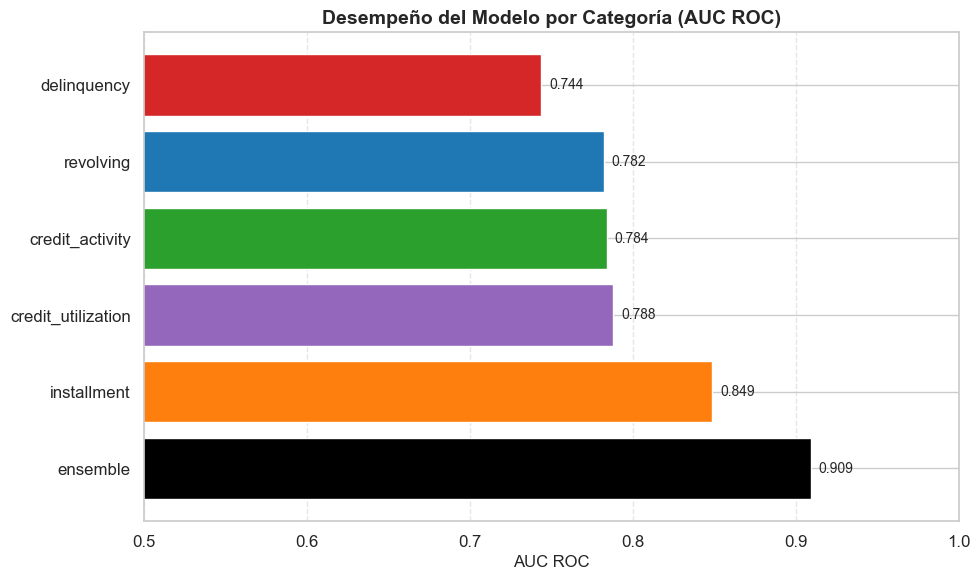

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Paleta de colores definida (de la curva ROC)
custom_colors = {
    "revolving": "#1f77b4",           # azul
    "installment": "#ff7f0e",         # naranja
    "credit_activity": "#2ca02c",     # verde
    "delinquency": "#d62728",         # rojo
    "credit_utilization": "#9467bd",  # morado
    "ensemble": "black"               # negro
}

# Ordenar por AUC descendente
sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
model_names, auc_values = zip(*sorted_auc)

# Estilo visual
sns.set(style="whitegrid", font_scale=1.1)

# Gráfica
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, auc_values, color=[custom_colors[name] for name in model_names])

# Etiquetas en barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va='center', fontsize=10)

# Estética
plt.xlabel('AUC ROC', fontsize=12)
plt.title('Desempeño del Modelo por Categoría (AUC ROC)', fontsize=14, weight='bold')
plt.xlim(0.5, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



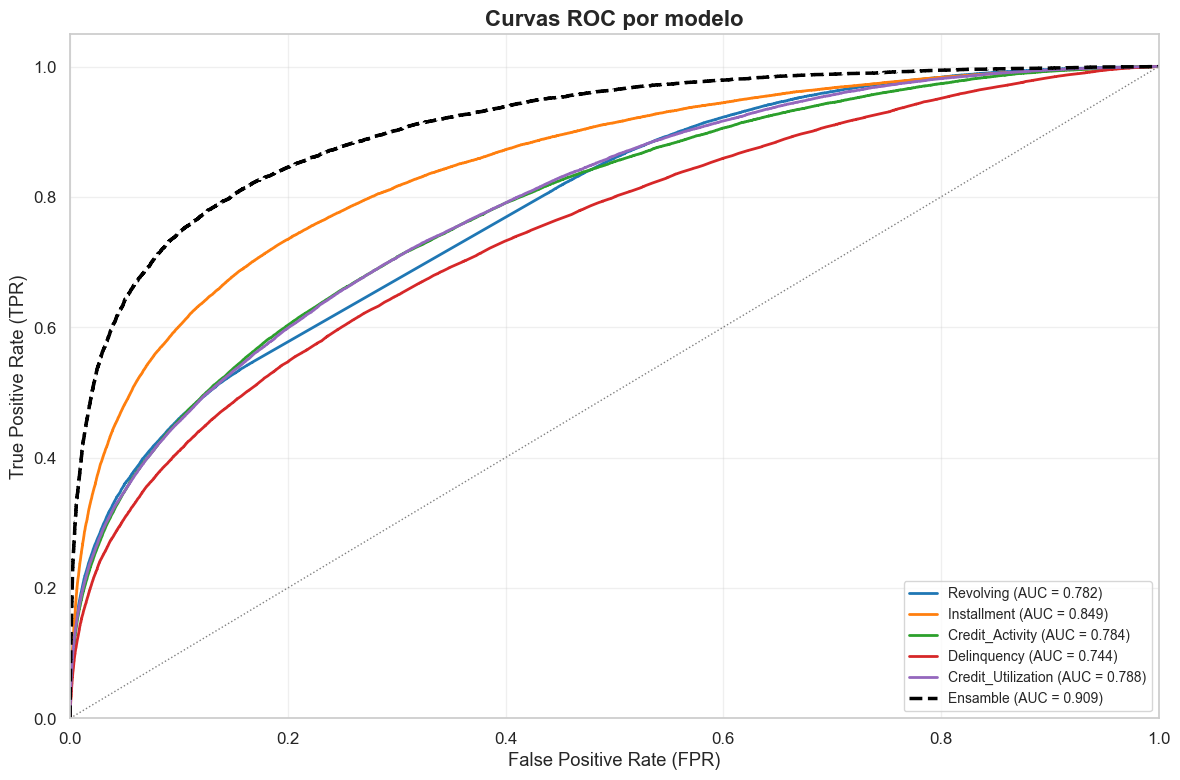

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Estilo general
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(12, 8))

# Paleta de colores automática
colors = sns.color_palette("tab10", n_colors=len(predictions) + 1)

# Graficar cada modelo individual
for i, pred_df in enumerate(predictions):
    model_name = [col for col in pred_df.columns if col.startswith("pred_")][0].replace("pred_", "")
    y_true = y_true_global.set_index("ID_UNICO")[target_column].loc[pred_df["ID_UNICO"]]
    y_score = pred_df[f"pred_{model_name}"]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f"{model_name.title()} (AUC = {roc_auc:.3f})")

# Añadir curva del ensamble
fpr_ens, tpr_ens, _ = roc_curve(y_test_ens, y_ens_pred)
roc_auc_ens = auc(fpr_ens, tpr_ens)
plt.plot(fpr_ens, tpr_ens, lw=2.5, color="black", linestyle='--', label=f"Ensamble (AUC = {roc_auc_ens:.3f})")

# Línea aleatoria
plt.plot([0, 1], [0, 1], linestyle=':', color='gray', lw=1)

# Estética del gráfico
plt.title("Curvas ROC por modelo", fontsize=16, weight="bold")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc="lower right", frameon=True, fontsize=10)
plt.tight_layout()
plt.show()


In [101]:
# Cargar modelos desde carpeta
modelos = {}
ruta_modelos = "../modelos"

for nombre_archivo in os.listdir(ruta_modelos):
    if nombre_archivo.endswith(".sav") and "modelo_" in nombre_archivo:
        nombre_modelo = nombre_archivo.replace("modelo_", "").replace(".sav", "")
        modelos[nombre_modelo] = joblib.load(os.path.join(ruta_modelos, nombre_archivo))

In [102]:
# Diccionario de DataFrames por categoría
dataframes_completos = {
    "revolving": df_revolvente,
    "installment": df_instalment,
    "credit_activity": df_credit_activity,
    "delinquency": df_delinquency,
    "credit_utilization": df_credit_utilization
}

In [103]:
# Inicializar lista para resultados
predicciones_full = []

for categoria, df_cat in dataframes_completos.items():
    if df_cat.empty:
        continue

    # Copia para no alterar el original
    df = df_cat.copy()
    df = df.reset_index(drop=True)

    # Crear ID_UNICO si no existe
    df["ID_UNICO"] = df["CLIENTEID"].astype(str) + "_" + df["MES_INFORMACION"].astype(str)

    # Separar features
    columnas_excluir = ["EVER30_12M", "ID_UNICO", "CLIENTEID", "MES_INFORMACION"]
    columnas_input = [col for col in df.columns if col not in columnas_excluir]

    X_full = df[columnas_input]

    # Obtener predicciones
    modelo = modelos[categoria]
    df[f"pred_{categoria}"] = modelo.predict_proba(X_full)[:, 1]

    # Agregar columna de ORIGEN
    df["ORIGEN"] = "FULL"

    # Guardar columnas clave + predicción
    predicciones_full.append(
        df[["ID_UNICO", "CLIENTEID", "MES_INFORMACION", f"pred_{categoria}", "EVER30_12M"]]
    )

In [104]:
# Ensamble (requiere que predicciones individuales estén primero)
df_merge = predicciones_full[0]
for df_pred in predicciones_full[1:]:
    df_merge = df_merge.merge(df_pred, on=["ID_UNICO", "CLIENTEID", "MES_INFORMACION", "EVER30_12M"], how="outer")

In [105]:
# Preparar variables para ensamble
X_ens = df_merge[[col for col in df_merge.columns if col.startswith("pred_") and "ensemble" not in col]]

In [106]:
# Cargar modelo de ensamble y predecir
modelo_ensamble = modelos["ensamble"]
df_merge["pred_ensemble"] = modelo_ensamble.predict_proba(X_ens)[:, 1]

In [108]:
# Mostrar resultado final
df_merge.tail(20)

,ID_UNICO,CLIENTEID,MES_INFORMACION,pred_revolving,EVER30_12M,pred_installment,pred_credit_activity,pred_delinquency,pred_credit_utilization,pred_ensemble
830679,999537_202204,999537,202204,0.046369,0,0.110209,0.169717,0.145675,0.124310,0.053438
830680,999537_202205,999537,202205,0.044172,0,0.079624,0.394333,0.084750,0.092002,0.058088
830681,999537_202206,999537,202206,0.080057,0,0.055276,0.023456,0.117907,0.088519,0.004503
830682,999537_202207,999537,202207,0.042393,0,0.054695,0.038424,0.167416,0.080354,0.025381
830683,999537_202208,999537,202208,0.204923,0,0.016840,0.051925,0.117843,0.061803,0.019897
830684,999537_202209,999537,202209,0.188158,0,0.035264,0.078701,0.114095,0.033854,0.030707
830685,999537_202210,999537,202210,0.177744,0,0.046918,0.087441,0.026150,0.037015,0.010506
830686,999537_202211,999537,202211,0.219903,0,0.054104,0.075044,0.027946,0.017961,0.030370
830687,999537_202212,999537,202212,0.237628,0,0.037459,0.082640,0.087945,0.013177,0.014841
830688,999537_202301,999537,202301,0.324097,0,0.027452,0.035563,0.162884,0.015275,0.011614


In [120]:
# Crear columna a partir del número entero MES_INFORMACION (ej. 202204)
df_merge["MES_INFORMACION_2"] = pd.to_datetime(df_merge["MES_INFORMACION"].astype(str) + "01", format="%Y%m%d")
df_merge["MES_INFORMACION_2"] = df_merge["MES_INFORMACION_2"].dt.strftime("%Y-%m-%d")



In [121]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830699 entries, 0 to 830698
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID_UNICO                 830699 non-null  object 
 1   CLIENTEID                830699 non-null  int64  
 2   MES_INFORMACION          830699 non-null  int64  
 3   pred_revolving           830699 non-null  float32
 4   EVER30_12M               830699 non-null  int64  
 5   pred_installment         830699 non-null  float32
 6   pred_credit_activity     830699 non-null  float32
 7   pred_delinquency         830699 non-null  float32
 8   pred_credit_utilization  830699 non-null  float32
 9   pred_ensemble            830699 non-null  float32
 10  MES_INFORMACION_2        830699 non-null  object 
dtypes: float32(6), int64(3), object(2)
memory usage: 50.7+ MB


In [123]:
df_merge

,ID_UNICO,CLIENTEID,MES_INFORMACION,pred_revolving,EVER30_12M,pred_installment,pred_credit_activity,pred_delinquency,pred_credit_utilization,pred_ensemble,MES_INFORMACION_2
0,1000320_202201,1000320,202201,0.162037,0,0.019864,0.078334,0.093230,0.078505,0.019223,2022-01-01
1,1000320_202202,1000320,202202,0.162037,0,0.012194,0.080132,0.064700,0.062816,0.018942,2022-02-01
2,1000320_202203,1000320,202203,0.162037,0,0.010958,0.122770,0.064700,0.065678,0.020641,2022-03-01
3,1000320_202204,1000320,202204,0.162037,0,0.003877,0.071479,0.064700,0.092936,0.017378,2022-04-01
4,1000320_202205,1000320,202205,0.162037,0,0.004753,0.051762,0.064700,0.071990,0.047173,2022-05-01
...,...,...,...,...,...,...,...,...,...,...,...
830694,999537_202307,999537,202307,0.086267,0,0.053320,0.184657,0.017179,0.005071,0.016361,2023-07-01
830695,999537_202308,999537,202308,0.122788,0,0.091155,0.103000,0.030616,0.003528,0.001853,2023-08-01
830696,999537_202309,999537,202309,0.177053,0,0.053609,0.101491,0.113791,0.004753,0.015425,2023-09-01
830697,999537_202310,999537,202310,0.261041,0,0.012951,0.019220,0.117357,0.013409,0.002142,2023-10-01


In [110]:
df_merge['EVER30_12M'].sum()

np.int64(141574)

# SUBIR RESULTADOS A BIGQUERY

In [ ]:
#! pip install pandas-gbq google-auth

In [126]:
df_atributos = pd.read_csv('../data/atributos_cliente.csv')

In [127]:
df_atributos

,CLIENTEID,DESEMPENIO,MIS,TIPOCLIENTE,VINTAGE,SEGMENTO_RIESGO,NOMBRE_SUCURSAL,REGION
0,1839,202201,2022-01-01,FORMERS,202112,1_AZUL,SAN FRANCISCO,NORTE
1,1839,202202,2022-02-01,FORMERS,202112,1_AZUL,SAN FRANCISCO,NORTE
2,1839,202203,2022-03-01,FORMERS,202112,1_AZUL,SAN FRANCISCO,NORTE
3,1839,202204,2022-04-01,FORMERS,202112,1_AZUL,SAN FRANCISCO,NORTE
4,1839,202205,2022-05-01,FORMERS,202112,1_AZUL,SAN FRANCISCO,NORTE
...,...,...,...,...,...,...,...,...
1315082,4945229,202504,2025-04-01,NUEVOS,202504,6_ROJO,MODESTO,SUR
1315083,4945296,202504,2025-04-01,NUEVOS,202504,4_NARANJA,HAYWARD,NORTE
1315084,4945305,202504,2025-04-01,NUEVOS,202504,3_AMARILLO,SAN RAFAEL,NORTE
1315085,4945361,202504,2025-04-01,NUEVOS,202504,4_NARANJA,HAYWARD,NORTE


In [128]:
# Seleccionar solo las columnas necesarias de df_atributos (para evitar duplicidad innecesaria)
cols_atributos = [
    "CLIENTEID", "DESEMPENIO",
    "TIPOCLIENTE", "VINTAGE", "SEGMENTO_RIESGO", "NOMBRE_SUCURSAL", "REGION"
]

# Hacemos el merge con left join
df_bq = df_merge.merge(
    df_atributos[cols_atributos],
    how="left",
    left_on=["CLIENTEID", "MES_INFORMACION"],   
    right_on=["CLIENTEID", "DESEMPENIO"]
)

df_bq.drop(columns=["DESEMPENIO"], inplace=True)


In [129]:
df_bq

,ID_UNICO,CLIENTEID,MES_INFORMACION,pred_revolving,EVER30_12M,pred_installment,pred_credit_activity,pred_delinquency,pred_credit_utilization,pred_ensemble,MES_INFORMACION_2,TIPOCLIENTE,VINTAGE,SEGMENTO_RIESGO,NOMBRE_SUCURSAL,REGION
0,1000320_202201,1000320,202201,0.162037,0,0.019864,0.078334,0.093230,0.078505,0.019223,2022-01-01,FORMERS,202102,3_AMARILLO,OAKLAND,NORTE
1,1000320_202202,1000320,202202,0.162037,0,0.012194,0.080132,0.064700,0.062816,0.018942,2022-02-01,FORMERS,202102,3_AMARILLO,OAKLAND,NORTE
2,1000320_202203,1000320,202203,0.162037,0,0.010958,0.122770,0.064700,0.065678,0.020641,2022-03-01,FORMERS,202102,3_AMARILLO,OAKLAND,NORTE
3,1000320_202204,1000320,202204,0.162037,0,0.003877,0.071479,0.064700,0.092936,0.017378,2022-04-01,FORMERS,202102,3_AMARILLO,OAKLAND,NORTE
4,1000320_202205,1000320,202205,0.162037,0,0.004753,0.051762,0.064700,0.071990,0.047173,2022-05-01,FORMERS,202102,3_AMARILLO,OAKLAND,NORTE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830695,999537_202307,999537,202307,0.086267,0,0.053320,0.184657,0.017179,0.005071,0.016361,2023-07-01,FORMERS,202110,1_AZUL,SACRAMENTO,NORTE
830696,999537_202308,999537,202308,0.122788,0,0.091155,0.103000,0.030616,0.003528,0.001853,2023-08-01,FORMERS,202110,1_AZUL,SACRAMENTO,NORTE
830697,999537_202309,999537,202309,0.177053,0,0.053609,0.101491,0.113791,0.004753,0.015425,2023-09-01,FORMERS,202110,1_AZUL,SACRAMENTO,NORTE
830698,999537_202310,999537,202310,0.261041,0,0.012951,0.019220,0.117357,0.013409,0.002142,2023-10-01,FORMERS,202110,1_AZUL,SACRAMENTO,NORTE


In [130]:
import pandas as pd
from pandas_gbq import to_gbq
from google.oauth2 import service_account

# Configura tu información
project_id = "gen-lang-client-0594597393"
dataset_table = "analisis_buro.predicciones_buro"
path_credenciales = "../credenciales.json"

# Autenticación
credenciales = service_account.Credentials.from_service_account_file(path_credenciales)

# Subir DataFrame
to_gbq(
    dataframe=df_bq,
    destination_table=dataset_table,
    project_id=project_id,
    credentials=credenciales,
    if_exists="replace"  # opciones: 'fail', 'replace', 'append'
)


100%|██████████| 1/1 [00:00<00:00, 5047.30it/s]
